In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import jax.numpy as jnp
from jax import grad, vmap
import jax
import jax.random as jrandom
import matplotlib.pyplot as plt
from utils import prepare_data
from models import *
from advi import *

## Faces Experiments 

In [11]:
from scipy.io import loadmat

all_data = loadmat("data/frey_rawface.mat")
data = all_data["ff"].T

In [12]:
rank = 10
nmf_model = NMF_Model_PoissonGamma(data, rank, gamma_prior_shape=1, gamma_prior_scale=1)
nmf_dim = nmf_model.dim
k = jrandom.key(15)
trial_vec = jrandom.normal(k, shape=(nmf_dim,))
theta, beta = nmf_model.t_inv_map(trial_vec)
nmf_advi = mean_field_advi(nmf_model)




In [13]:
nmf_advi = mean_field_advi(nmf_model)
nmf_advi.run_advi(k, 10, 5001, 1e-6, print_every=500, adaptive=True)


-51112680.0
-9866147.0
-7819577.0
-7223230.5
-6999675.5
-6917121.5
-6884717.0
-6870720.0
-6855644.0
-6815347.5
-6695331.5


[Array(-51112680., dtype=float32),
 Array(-46747676., dtype=float32),
 Array(-46051976., dtype=float32),
 Array(-44421964., dtype=float32),
 Array(-41848092., dtype=float32),
 Array(-39465340., dtype=float32),
 Array(-38751860., dtype=float32),
 Array(-37965824., dtype=float32),
 Array(-37184588., dtype=float32),
 Array(-36295484., dtype=float32),
 Array(-35252572., dtype=float32),
 Array(-35190592., dtype=float32),
 Array(-34499104., dtype=float32),
 Array(-33861160., dtype=float32),
 Array(-33581096., dtype=float32),
 Array(-33092256., dtype=float32),
 Array(-32437990., dtype=float32),
 Array(-32233478., dtype=float32),
 Array(-31666042., dtype=float32),
 Array(-31007124., dtype=float32),
 Array(-31219782., dtype=float32),
 Array(-30971750., dtype=float32),
 Array(-30599366., dtype=float32),
 Array(-30604406., dtype=float32),
 Array(-30317894., dtype=float32),
 Array(-29990404., dtype=float32),
 Array(-29682330., dtype=float32),
 Array(-29227584., dtype=float32),
 Array(-29469066., d

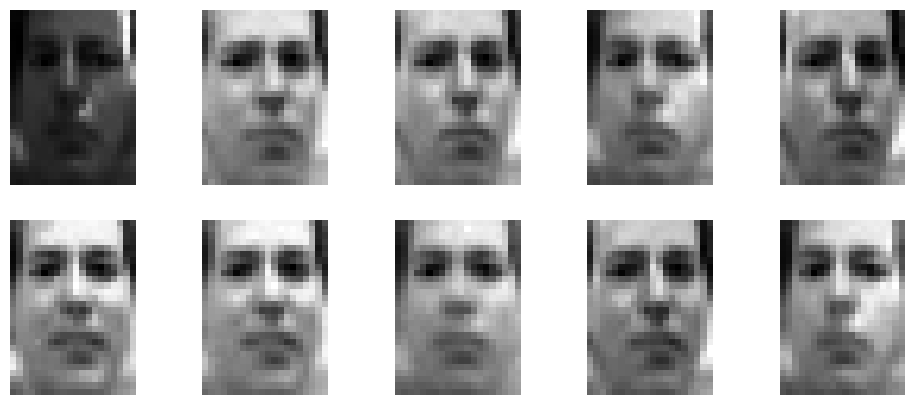

In [16]:
thetas, betas = nmf_model.t_inv_map(nmf_advi.params["mu"])

u = 42
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(betas[i].reshape(28, 20), cmap="gray")
    axs[i].axis("off")
    # axs[i].set_title(rf"$\beta_{{{i}}}$")
    
plt.savefig("face_poisson gamma.pdf")

In [33]:
rank = 10
all_data = loadmat("data/frey_rawface.mat")
data = all_data["ff"].T
nmf_model = NMF_Model_PoissonDirExp(data, rank,dir_prior=100, exp_prior=0.5)
nmf_dim = nmf_model.dim
k = jrandom.key(15)
trial_vec = jrandom.normal(k, shape=(nmf_dim,))
theta, beta = nmf_model.t_inv_map(trial_vec)
nmf_advi = mean_field_advi(nmf_model)
nmf_advi.run_advi(k, 10, 5001, 1e-5, print_every=500, adaptive=True)


thetas, betas = nmf_model.t_inv_map(nmf_advi.params["mu"])

u = 42
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(betas[i].reshape(28, 20), cmap="gray")
    axs[i].axis("off")
    # axs[i].set_title(rf"$\beta_{{{i}}}$")

-1676490000.0
-1109218400.0


KeyboardInterrupt: 

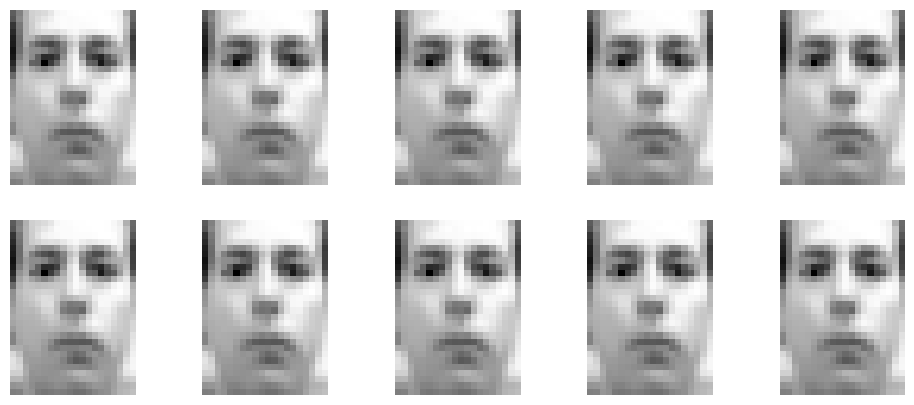

In [34]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(betas[i].reshape(28, 20), cmap="gray")
    axs[i].axis("off")
    # axs[i].set_title(rf"$\beta_{{{i}}}$")

In [ ]:
u = 25
plt.figure()
plt.subplot(121)
plt.imshow((thetas[u] @ betas).reshape(28, 20), cmap="gray")
plt.axis("off")
plt.title(rf"$\theta_{{{u}}}\cdot\beta$")
plt.subplot(122)
plt.imshow((data[u]).reshape(28, 20), cmap="gray")
plt.title(rf"$Y_{{{u}, true}}$")
plt.axis("off")
print(f"theta_{u}: {thetas[u]}")